In [64]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn, optim

from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

In [65]:
# Normal dataset
df = pd.read_csv('smallDomainDataNotEmbedded.csv')

def CleanText(text):
    text = text.lower() #Turn all text entries into lower-case
    text = re.sub(r'''(https?:\/\/www\.|https?:\/\/)?[a-z0-9]+([\-\.]{1}[a-z0-9]+)*\.[a-z]{2,3}[-a-zA-Z0-9()@:%_\+.~#?&\//=<>]*''', "<URL>", text)
    #Replace URL with tag
    text = re.sub(r'''[0-9]+[/\-.]+[0-9]+[/\-.]+[0-9]+''', "<DATE>", text) #Replace dates with tag
    text = re.sub(r'''[a-z0-9._%+-]+\@[a-z0-9.-]+[a-z0-9]\.[a-z]{1,}''', "<EMAIL>", text)
    text = re.sub(r'''[0-9]+''', "<NUM>", text) #Replace numbers with tag
    text = re.sub(r'''[.|,|!|?|\'|\''|\"|\n|\t|\-|\(|\)]''', '', text)
    text = re.sub(r'''^\s+|\s+$''', '', text) #Remove whitespaces at the end and start of string
    text = re.sub(r'''[ ][ ]+|_''', " ", text) #Remove multiple whitespace
    if len(text) <= 0:
        text = re.sub(r'''''', "0", text) #Remove multiple whitespace
    return text

df['comment_text'] = df['comment_text'].apply(lambda text: CleanText(text))
    


In [66]:
# Updating values for training_data
training_data = df[df['split'] == 'train']

# Getting test_data
test_data = df[df['split'] == 'test']

# Getting validation_data
validation_data = df[df['split'] == 'val']

In [67]:
# Creating data loaders
X_train = np.array(training_data['comment_text'].values.tolist())
Y_train = np.array(training_data['toxicity'].values.tolist())

X_test = np.array(test_data['comment_text'].values.tolist())
Y_test = np.array(test_data['toxicity'].values.tolist())

X_val = np.array(validation_data['comment_text'].values.tolist())
Y_val = np.array(validation_data['toxicity'].values.tolist())


# Creating TF-IDF
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
X_val = vectorizer.transform(X_val)

X_train = X_train.toarray()
X_test = X_test.toarray()
X_val = X_val.toarray()

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, Y_train)
print("LogisticRegression score: ",clf.score(X_test, Y_test))

from sklearn.linear_model import Perceptron

clf = Perceptron()
clf.fit(X_train, Y_train)
print("Perceptron score: ",clf.score(X_test, Y_test))

from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, Y_train)
print("KNN score: ", clf.score(X_test, Y_test))

In [68]:
### Set parameters for the model
#torch.manual_seed(42) # set fixed random seed for reproducibility
batch_size = 16
epochs = 1000
lr = 0.00001

cuda = True # Set this if training on GPU
cuda = cuda and torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print("Using "+repr(device))

Using device(type='cuda')


In [69]:
prepare_trainloader = []
for i in range(len(X_train)):
    prepare_trainloader.append([X_train[i], Y_train[i]])
    
prepare_testloader = []
for i in range(len(X_test)):
    prepare_testloader.append([X_test[i], Y_test[i]])
    
prepare_validloader = []
for i in range(len(X_val)):
    prepare_validloader.append([X_val[i], Y_val[i]])

train_loader = torch.utils.data.DataLoader(prepare_trainloader, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(prepare_validloader, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(prepare_testloader, batch_size=batch_size, shuffle=False)

In [70]:
def CheckAccuracy(predictions, labels):
        acc = 0.0
        for i in range(len(predictions)):
            if (predictions[i] == labels[i]):
                acc += 1
        return acc/len(predictions)

In [73]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Sequential(nn.Linear(9620, 512), nn.ReLU(), nn.Dropout(p=0.8))
        self.fc2 = nn.Sequential(nn.Linear(512, 32), nn.ReLU())
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [79]:
# Setting up model parameters
model = Net().to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr)
loss_function = nn.BCELoss()

# Initialising early stopping criterias
early_stopping = 50
notImproved = 0
bestLoss = None
bestModel = None

trainArr = []
valArr = []

bestf1 = 0
bestEpoch = 0

for epoch in range(1, epochs + 1):
    
    train_loss = 0.0
    for batch_idx, data in enumerate(train_loader):
        
        # get the input
        inputs, labels = data
    
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        
        outputs = model(inputs)
        outputs = outputs.squeeze(1)
        
        loss = loss_function(outputs, labels)
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader.dataset)
    
    
    trainArr.append(train_loss)
    
    valid_loss = 0
    labs = []
    preds = []
    
    model.eval()
    with torch.no_grad():        
        for batch_idx, data in enumerate(valid_loader):
            # get the input
            inputs, labels = data
            
            inputs = inputs.to(device).float()
            labels = labels.to(device).float()
            
            outputs = model(inputs).squeeze()
            
            labs.extend(labels)
            preds.extend(torch.round(outputs))
            
            valid_loss += loss_function(outputs, labels).item()
    
    valid_loss /= len(valid_loader.dataset)
    valArr.append(valid_loss)
    
    #print(CheckAccuracy(labs, preds))
    
    if bestLoss == None:
        bestLoss = valid_loss
    
    if valid_loss <= bestLoss:
        bestModel = model
        bestLoss = valid_loss
        notImproved = 0
        bestEpoch = epoch
    
    else:
        notImproved +=1
        
    if notImproved >= early_stopping:
        break

model = bestModel

print(bestEpoch)

51


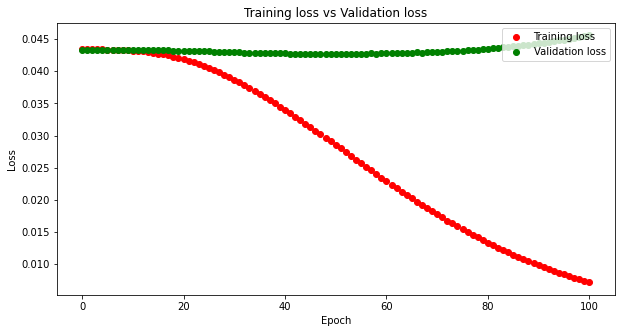

In [80]:
plt.figure(figsize=(10,5))
plt.scatter(np.arange(0,len(trainArr)), trainArr, color='r', label='Training loss')
plt.scatter(np.arange(0,len(valArr)), valArr, color='g', label='Validation loss')
plt.title("Training loss vs Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

In [83]:
def F1_Scores(preds, labels):
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    for i in range(len(labs)):
        if labels[i]==1 and preds[i]==1:
            true_positives += 1
        if labels[i]==0 and preds[i]==0:
            true_negatives += 1
        if labels[i]==0 and preds[i]==1:
            false_positives += 1
        if labels[i]==1 and preds[i]==0:
            false_negatives += 1
    print("true_positives", true_positives)
    print("true_negatives", true_negatives)
    print("false_positives", false_positives)
    print("false_negatives", false_negatives)
    
    return true_positives, true_negatives, false_positives, false_negatives

In [84]:
labs = []
preds = []

model.eval()
with torch.no_grad():        
    for batch_idx, data in enumerate(test_loader):
        # get the input
        inputs, labels = data
        inputs = inputs.unsqueeze(1)
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()
        
        outputs = model(inputs).squeeze()
        
        labs.extend(labels)
        preds.extend(torch.round(outputs))
        
print("Accuracy on test set: ", CheckAccuracy(labs, preds))

f1 = f1_score(torch.Tensor(labs).numpy(), torch.Tensor(preds).numpy(), zero_division=1)
print("F1_score: ", f1)


model.eval()
with torch.no_grad():        
    for batch_idx, data in enumerate(valid_loader):
        # get the input
        inputs, labels = data
        inputs = inputs.unsqueeze(1)
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()
        
        outputs = model(inputs).squeeze()
        
        labs.extend(labels)
        preds.extend(torch.round(outputs))
        
print("Accuracy on validation set: ", CheckAccuracy(labs, preds))

model.eval()
with torch.no_grad():        
    for batch_idx, data in enumerate(train_loader):
        # get the input
        inputs, labels = data
        inputs = inputs.unsqueeze(1)
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()
        
        outputs = model(inputs).squeeze()
        
        labs.extend(labels)
        preds.extend(torch.round(outputs))
        
print("Accuracy on train set: ", CheckAccuracy(labs, preds))



true_positives, true_negatives, false_positives, false_negatives = F1_Scores(preds, labs)

Accuracy on test set:  0.6083333333333333
F1_score:  0.5714285714285714
Accuracy on validation set:  0.5979166666666667
Accuracy on train set:  0.7972027972027972
true_positives 1069
true_negatives 1211
false_positives 219
false_negatives 361
